# Mobile price classification

#### The dataset can be found at https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification

## Load necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

# Sklearn 
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

# Hyperopt and LightGBM
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import lightgbm as lgb

## Load data and get information about data

In [2]:
data = pd.read_csv('/kaggle/input/mobile-price-classification/train.csv')

def data_information(data, describe = False, dtypes = False):
    data.drop_duplicates(inplace = True)

    if describe:
        print(data.describe())
    if dtypes:
        print(data.dtypes)
    
    for column in data.columns:
        if data[column].isnull().sum() > 0:
            print(column + ' has ' + str(data[column].isnull().sum()) + ' missing values')
    return data
data = data_information(data)

data.head(n = 5)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


## Correlation

#### A correlation plot can be nice to visualize which features have a large correlation, but with many features, it can become a bit messy. We therefore print out the features that have large correlation between each other.

In [3]:
def correlation(data, p):
    print('Number of features:', len(data.columns))
    columns1 = columns2 = data.columns
    for coli in columns1:
        columns2 = columns2.drop(coli)
        for colj in columns2:
            corr = data[coli].corr(data[colj])
            if np.abs(corr) >= p:
                print('Correlation between ' + coli + ' and ' + colj + ' is ' + str(np.round(corr,3)))
correlation(data, 0.5)

Number of features: 21
Correlation between fc and pc is 0.645
Correlation between four_g and three_g is 0.584
Correlation between px_height and px_width is 0.511
Correlation between ram and price_range is 0.917
Correlation between sc_h and sc_w is 0.506


## Pairplot

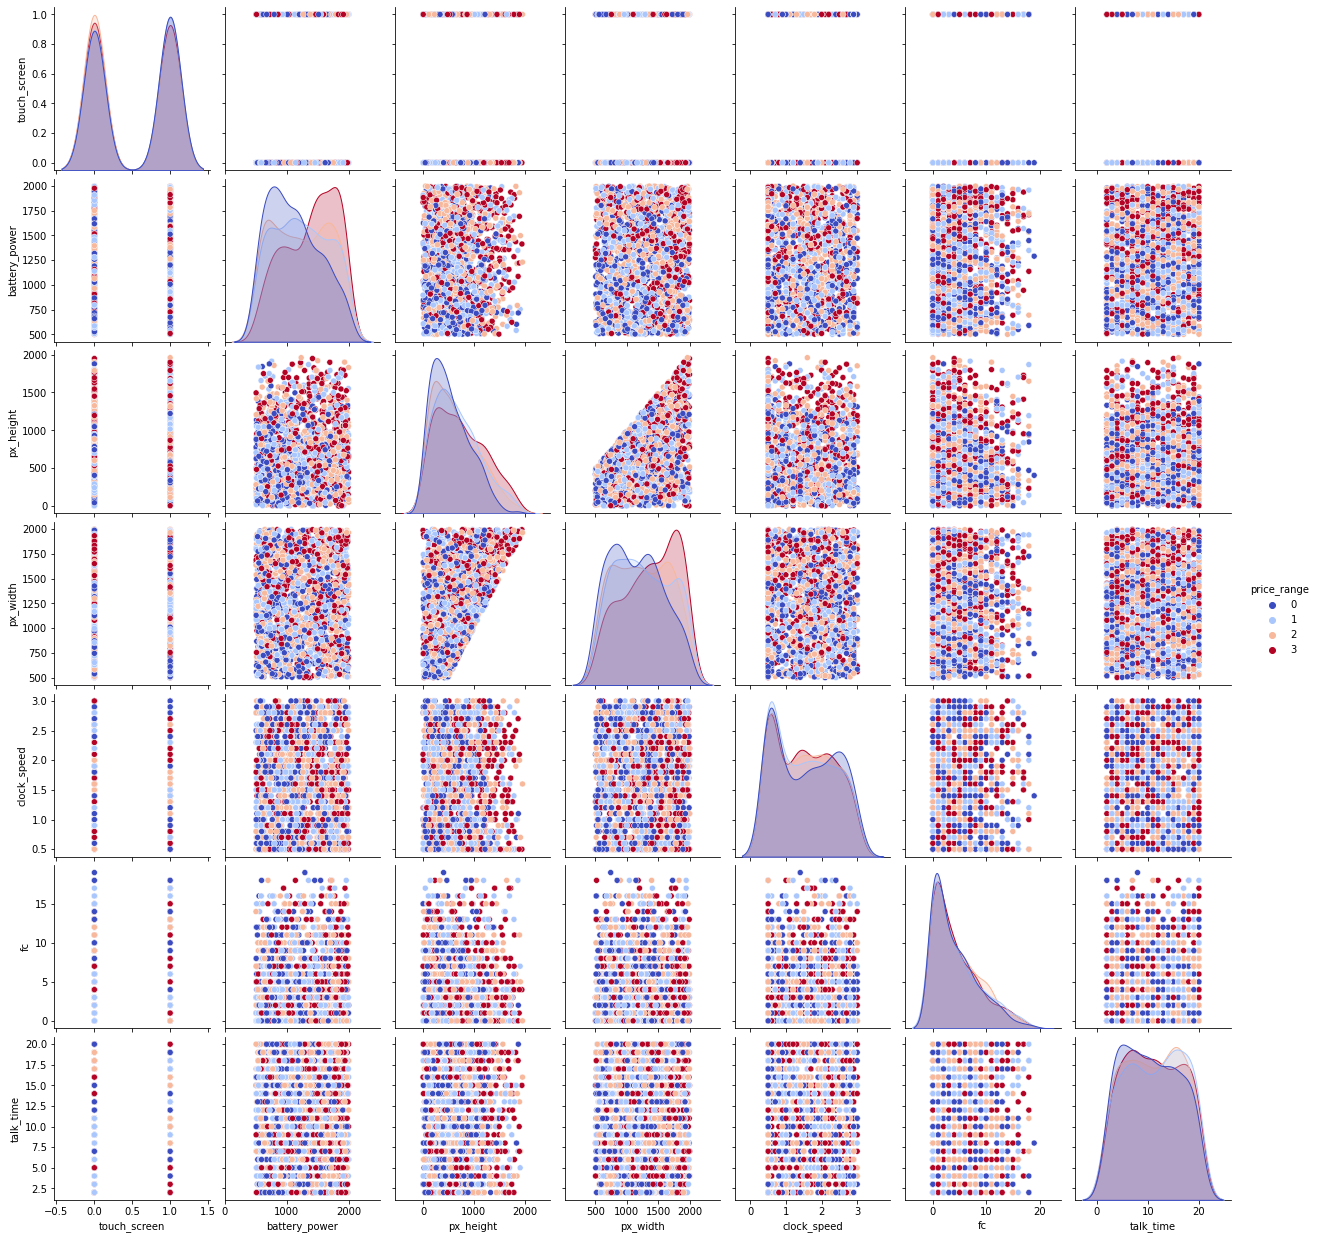

In [4]:
plot_feat = ['price_range', 'touch_screen', 'battery_power', 'px_height', 'px_width', 'clock_speed', 'fc', 'talk_time']
sns.pairplot(data[plot_feat], hue = 'price_range', palette = 'coolwarm')
plt.show()

## Features to use in model

In [5]:
data['mobile_ratio'] = data['px_height'] * data['px_width'] # create new feature

# Remove price_range from our features
features = []
for i in data.columns:
    features.append(i)
features.remove('price_range')
print('Features: ', features)

X = data[features]
y = data['price_range']

# Split dataset into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, shuffle=True)
dataset = [X_train, y_train, X_test, y_test]

Features:  ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'mobile_ratio']


## LightGBM basemodel and feature importance

#### We observe that the four most important features, according to LightGBMs feature importance plot, are ram, battery power, mobile ratio, pixel width and pixel height. 

In [6]:
def feature_importance(model):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

def evaluate(dataset, model, feature_imp = False):
    X_train, y_train, X_test, y_test = dataset
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print('F1 score: ', np.round(np.mean(f1_score(y_pred,y_test, average = None)),2))
    
    if feature_imp:
        feature_importance(model, X_train)
    return y_pred, confusion_matrix(y_test, y_pred)

y_pred1, cm1 = evaluate(dataset, lgb.LGBMClassifier())

F1 score:  0.89


## Parameter tuning

In [7]:
max_trials = 50
def Train_model(dataset, space, method = 'CV', max_trials = 50):
    X_train, y_train, X_test, y_test = dataset
    def objective(space):
        clf = lgb.LGBMClassifier(**space, random_state = 1)
        if method == 'CV':
            metric = - np.mean(cross_val_score(clf, X_train, y_train, 
                                               cv = 5, scoring = "neg_log_loss"))
        else:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            metric = - accuracy_score(y_pred,y_test)
        return{'loss': metric, 'status': STATUS_OK}
    trials = Trials()
    max_evals = max_trials
    rstate = np.random.seed(1)
    with trange(max_evals) as t:
        for e in t:
            best = fmin(fn=objective, space=space, 
                        algo = tpe.suggest,
                        rstate = rstate,
                        max_evals=e+1, trials=trials, 
                        show_progressbar=False, 
                        verbose = True)
            t.set_postfix(K=space_eval(space,best), best_loss=min(trials.losses()))
    return space_eval(space, best)

space = { 
    'n_estimators': hp.choice('n_estimators', range(500, 1001)),
    'learning_rate': hp.uniform('learning_rate',0.08, 0.15),
    'max_depth': hp.choice('max_depth', range(5, 9)),
    'num_leaves': hp.choice('num_leaves', range(5, 127)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 5),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'subsample_freq': hp.choice('subsample_freq', range(1,10)),
    'min_child_samples': hp.choice('min_data_in_leaf', range(20,100)), 
}

lgb_param = Train_model(dataset, space, max_trials = max_trials); print(lgb_param)
y_pred, cm2 = evaluate(dataset, lgb.LGBMClassifier(**lgb_param, random_state = 1))

100%|██████████| 50/50 [11:33<00:00, 13.87s/it, K={'colsample_bytree': 0.9529757161242364, 'learning_rate': 0.09816962795848137, 'max_depth': 6, 'min_child_samples': 36, 'n_estimators': 994, 'num_leaves': 7, 'reg_alpha': 1.1802822319491624, 'reg_lambda': 3.9379460873456638, 'subsample': 0.7612270229527932, 'subsample_freq': 1}, best_loss=0.215]  


{'colsample_bytree': 0.9529757161242364, 'learning_rate': 0.09816962795848137, 'max_depth': 6, 'min_child_samples': 36, 'n_estimators': 994, 'num_leaves': 7, 'reg_alpha': 1.1802822319491624, 'reg_lambda': 3.9379460873456638, 'subsample': 0.7612270229527932, 'subsample_freq': 1}
F1 score:  0.9


## Feature elimination

#### We use RFECV to do feature elimination

In [8]:
def feature_elimination(feature_model, X_train, X_test, method = 'RFECV', cv = 5):
    selector = RFECV(feature_model, step=1, cv= cv)
    selector = selector.fit(X_train, y_train)

    drop_features = []
    for i, feature in enumerate(X_train.columns):
        if selector.support_[i] == False:
            drop_features.append(feature)
            
    for i in drop_features:
        X_train.pop(i)
        X_test.pop(i)
    print('Features in reduced model: ', X_train.columns)
    return X_train, X_test
model = RandomForestClassifier(n_estimators = 500, random_state = 1)
X_train, X_test = feature_elimination(model, X_train, X_test)

Features in reduced model:  Index(['battery_power', 'px_width', 'ram', 'mobile_ratio'], dtype='object')


## Base model with reduced features

In [9]:
y_pred3, cm3 = evaluate(dataset, lgb.LGBMClassifier())

F1 score:  0.91


## Tuned model with reduced features

In [10]:
lgb_param = Train_model(dataset, space, max_trials = max_trials); print(lgb_param)
y_pred4, cm4 = evaluate(dataset, lgb.LGBMClassifier(**lgb_param, random_state = 1))

100%|██████████| 50/50 [09:50<00:00, 11.82s/it, K={'colsample_bytree': 0.9626677447921306, 'learning_rate': 0.11432150691503574, 'max_depth': 6, 'min_child_samples': 32, 'n_estimators': 947, 'num_leaves': 42, 'reg_alpha': 1.1526336904714152, 'reg_lambda': 2.3257291759842555, 'subsample': 0.5111230849746726, 'subsample_freq': 1}, best_loss=0.173] 


{'colsample_bytree': 0.9626677447921306, 'learning_rate': 0.11432150691503574, 'max_depth': 6, 'min_child_samples': 32, 'n_estimators': 947, 'num_leaves': 42, 'reg_alpha': 1.1526336904714152, 'reg_lambda': 2.3257291759842555, 'subsample': 0.5111230849746726, 'subsample_freq': 1}
F1 score:  0.93


## Results

#### We observe that our tuned model with reduced number of features perform best.

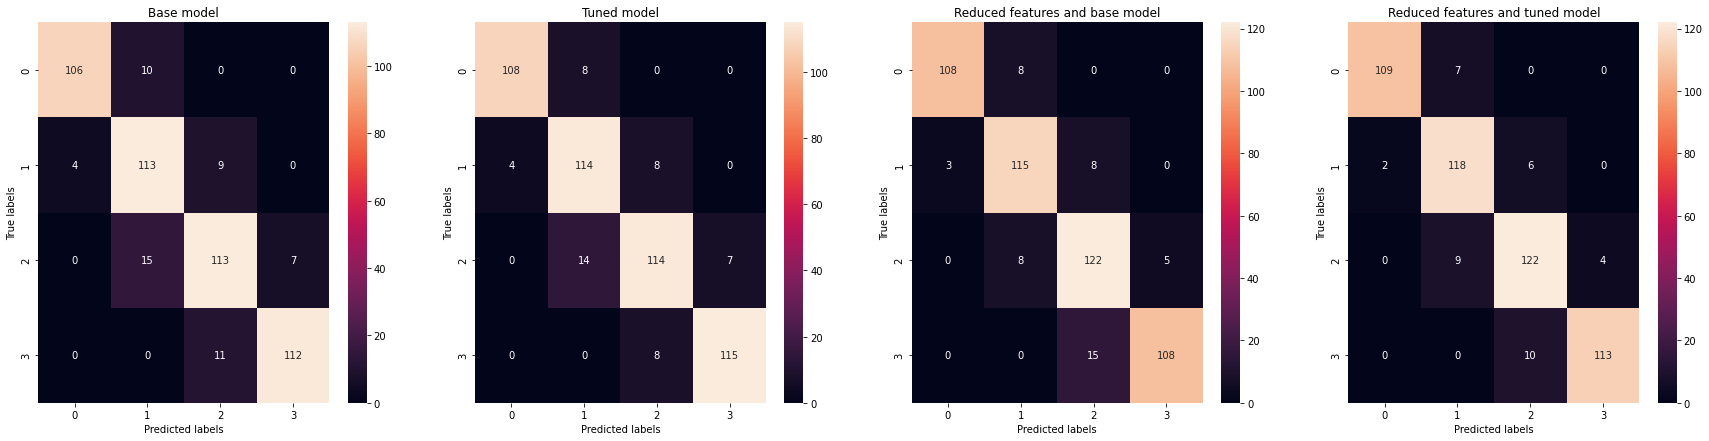

In [12]:
plt.figure(figsize = (30,7))
confmatrices = [cm1, cm2, cm3, cm4]
Titles = ['Base model', 'Tuned model', 'Reduced features and base model', 'Reduced features and tuned model']
for i, (title, cm) in enumerate(zip(Titles, confmatrices)):
    plt.subplot(1, len(Titles), i+1)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted labels'); plt.ylabel('True labels')
    plt.title(title)
plt.show()